# Visualization of the RBF Hessian GP used in BayeSQP


In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import torch
from botorch.models.transforms import Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from matplotlib.colors import Normalize

from bayesqp import RBFHessianGPModel, seed_everything

# Set default tensor type to double precision, this is highly recommended!
torch.set_default_dtype(torch.float64)


In [2]:
def visualize_2d_gp_hessian(model, x_train, n_test=50, figsize=(10, 7)):
    x1 = torch.linspace(
        (x_train[:, 0].min() - 0.1),
        (x_train[:, 0].max() + 0.1),
        n_test,
    )
    x2 = torch.linspace(
        (x_train[:, 1].min() - 0.1),
        (x_train[:, 1].max() + 0.1),
        n_test,
    )

    x1_grid, x2_grid = torch.meshgrid(x1, x2, indexing="ij")
    x_grid = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1)

    with torch.no_grad():
        model.eval()

        # Function predictions for grid
        y_pred = model.posterior(x_grid)
        mean = y_pred.mean.reshape(n_test, n_test)
        std = y_pred.variance.sqrt().reshape(n_test, n_test)

        # Gradient predictions for grid
        mean_grad, var_grad = model.posterior_derivative(x_grid)
        grad_x = mean_grad[:, 0].reshape(n_test, n_test)
        grad_y = mean_grad[:, 1].reshape(n_test, n_test)
        grad_magnitude = torch.sqrt(grad_x**2 + grad_y**2)

        # Gradient uncertainty (use Frobenius norm of covariance)
        grad_std = torch.sqrt(
            torch.diagonal(var_grad, dim1=1, dim2=2).sum(dim=1)
        ).reshape(n_test, n_test)

        # Hessian predictions for grid
        mean_hess = model.posterior_hessian_mean(x_grid)
        hess_xx = mean_hess[:, 0, 0].reshape(n_test, n_test)
        hess_xy = mean_hess[:, 0, 1].reshape(n_test, n_test)
        hess_yy = mean_hess[:, 1, 1].reshape(n_test, n_test)
        hess_det = hess_xx * hess_yy - hess_xy**2

        # Create figure with 2 rows, 3 columns
        fig = plt.figure(figsize=figsize, constrained_layout=True)
        gs = gridspec.GridSpec(2, 3, figure=fig)

        contour_levels = 20

        # ===== TOP ROW: Mean predictions =====

        # Plot function contour
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.contour(
            x1_grid.numpy(),
            x2_grid.numpy(),
            mean.numpy(),
            contour_levels,
            colors="k",
            linewidths=0.5,
            alpha=0.5,
        )
        ax1.contourf(
            x1_grid.numpy(),
            x2_grid.numpy(),
            mean.numpy(),
            contour_levels,
            cmap="Blues",
        )
        ax1.scatter(
            x_train[:, 0].numpy(),
            x_train[:, 1].numpy(),
            c="k",
            s=20,
            marker="o",
            label="Training data",
        )
        ax1.legend(
            loc="upper left",
            frameon=True,
            handlelength=1.5,
        )
        ax1.set_title("Zero-order prediction")

        # Plot gradient field
        ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
        ax2.contourf(
            x1_grid.numpy(),
            x2_grid.numpy(),
            grad_magnitude.numpy(),
            contour_levels,
            cmap="Blues",
        )
        stride = max(1, n_test // 15)
        ax2.quiver(
            x1_grid[::stride, ::stride].numpy(),
            x2_grid[::stride, ::stride].numpy(),
            grad_x[::stride, ::stride].numpy(),
            grad_y[::stride, ::stride].numpy(),
            color="k",
            scale=30,
            width=0.005,
            alpha=0.8,
        )
        ax2.set_title("Gradient field")

        # Plot Hessian determinant
        ax3 = fig.add_subplot(gs[0, 2], sharex=ax1, sharey=ax1)
        norm_det = Normalize(vmin=-abs(hess_det).max(), vmax=abs(hess_det).max())
        ax3.contourf(
            x1_grid.numpy(),
            x2_grid.numpy(),
            hess_det.numpy(),
            contour_levels,
            cmap="Blues",
            norm=norm_det,
        )
        ax3.contour(
            x1_grid.numpy(),
            x2_grid.numpy(),
            hess_det.numpy(),
            levels=[0],
            colors="k",
            linewidths=1.5,
            alpha=0.8,
        )

        contour_proxy = Line2D(
            [0],
            [0],
            color="k",
            linewidth=1.5,
            alpha=0.8,
            label="Critical point boundary",
        )
        ax3.legend(
            handles=[contour_proxy],
            loc="upper center",
            frameon=True,
            handlelength=1.5,
            borderpad=0.3,
        )
        ax3.set_title("Hessian determinant")

        # ===== BOTTOM ROW: Uncertainty plots =====

        # Function uncertainty
        ax4 = fig.add_subplot(gs[1, 0], sharex=ax1, sharey=ax1)
        ax4.contourf(
            x1_grid.numpy(),
            x2_grid.numpy(),
            std.numpy(),
            contour_levels,
            cmap="Reds",
        )
        ax4.scatter(
            x_train[:, 0].numpy(),
            x_train[:, 1].numpy(),
            c="k",
            s=20,
            marker="o",
        )
        ax4.set_title("Function uncertainty")

        # Gradient uncertainty
        ax5 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax1)
        ax5.contourf(
            x1_grid.numpy(),
            x2_grid.numpy(),
            grad_std.numpy(),
            contour_levels,
            cmap="Reds",
        )
        ax5.scatter(
            x_train[:, 0].numpy(),
            x_train[:, 1].numpy(),
            c="k",
            s=20,
            marker="o",
        )
        ax5.set_title("Gradient uncertainty (Frob. norm)")

        # Hessian uncertainty
        ax6 = fig.add_subplot(gs[1, 2], sharex=ax1, sharey=ax1)
        ax6.text(
            0.5,
            0.5,
            "Not implemented!",
            fontsize=12,
            ha="center",
            va="center",
            transform=ax6.transAxes,
        )
        ax6.set_title("Hessian uncertainty")

        # Add labels
        for ax in [ax1, ax2, ax3]:
            ax.set_xticklabels([])

        for ax in [ax4, ax5, ax6]:
            ax.set_xlabel("$x_0$")

        for ax in [ax1, ax4]:
            ax.set_ylabel("$x_1$")

        for ax in [ax2, ax3, ax5, ax6]:
            ax.set_yticklabels([])

        plt.tight_layout()
        return fig

/var/folders/b7/4sbb97gd7xdcbjt2mww_cxcr0000gn/T/ipykernel_36629/3331805701.py:207: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


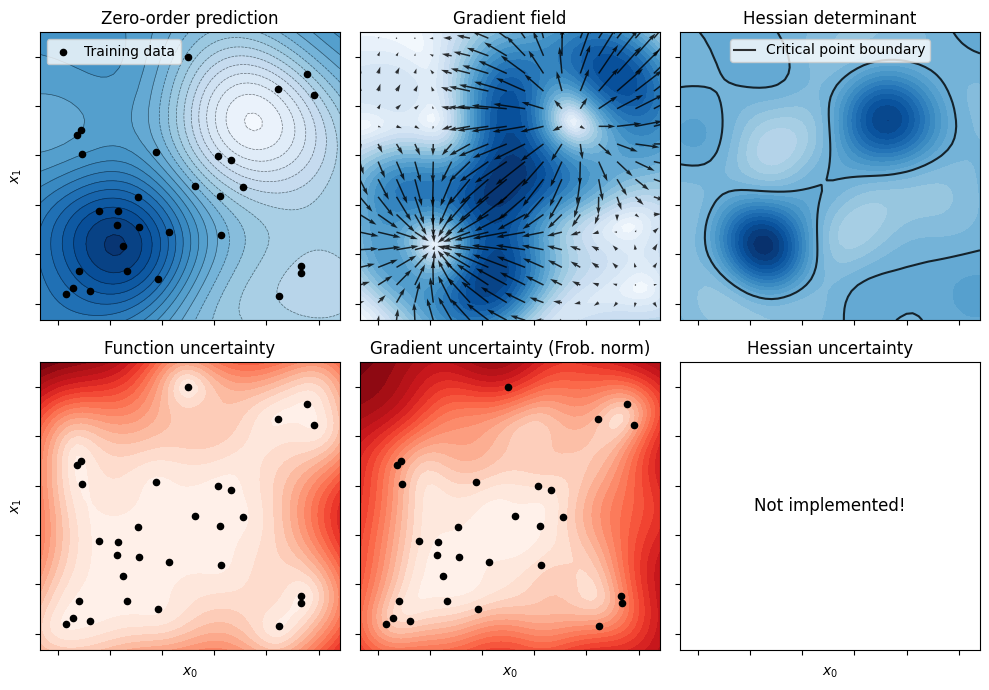

In [3]:
seed_everything(42)

n_train = 30
x_train = torch.rand(n_train, 2)


# The following function was generated with Claude
# Target function: a mixture of Gaussian bumps
def function(x):
    # Create a function with minima, maxima and saddle points
    g1 = torch.exp(
        -10 * ((x[:, 0] - 0.25) ** 2 + (x[:, 1] - 0.25) ** 2)
    )  # bump at (0.25, 0.25)
    g2 = -torch.exp(
        -10 * ((x[:, 0] - 0.75) ** 2 + (x[:, 1] - 0.75) ** 2)
    )  # pit at (0.75, 0.75)
    saddle = (x[:, 0] - 0.25) * (x[:, 1] - 0.75)  # saddle-like surface
    return g1 + g2 + saddle


y_train = function(x_train).reshape(-1, 1)
y_train = y_train + 0.02 * torch.randn(n_train, 1)

# Create and configure the GP model
model = RBFHessianGPModel(
    train_X=x_train,
    train_Y=y_train,
    outcome_transform=Standardize(m=1),
)

# Fit the model, NOTE: this only interacts with the "standard" marginal GP
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

fig = visualize_2d_gp_hessian(model, x_train)